In [9]:
from qiskit import *
from qiskit.circuit import Parameter, Gate
from qiskit.visualization import array_to_latex, plot_histogram
from qiskit.quantum_info import Operator

from qutip import tensor, sigmam, sigmap,sigmax, sigmay, sigmaz, qeye, mesolve, fock

import matplotlib.pyplot as plt
import numpy as np

# Hamiltonian Simulation - Ryan Dougherty

## Part 1) Simple Single Qubit Simulation:

Lets run a hamiltonian simulation for a single qubit that don't expirience any interaction or coupling. The hamiltonian for each qubit is given by:

$$H = \frac{\delta}{2} \sigma_z + \frac{\Omega}{2} \sigma_x $$

In my attached notes I calculate the time evolved matrix of this. We can write the single qubit time evolved hamiltonian U(t) as:

$$U(t) = R_{z}(\delta t) R_{x}(\Omega t) $$

lets go over an example where t=2.25sec and r=16. This makes our error $\epsilon$ equal to:

$$ \epsilon = \frac{t^2}{r} = \frac{2.25^2}{25} = 0.2025 $$

This makes our $\epsilon$ error approximately 20%, which should be plenty acceptable for our experiment.

First, let's build our U(t) for our hamiltonian simulation for $\delta$ = 0.5 and $\Omega$ = $2\pi$

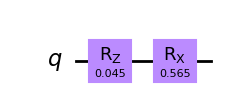

In [3]:
t = 2.25
r = 25
dt = t/r

delta = 0.5
Omega = 2*np.pi

qc = QuantumCircuit(1, name="U(dt={})".format(dt))

qc.rz(delta * dt, 0)
qc.rx(Omega * dt, 0)
U_t = qc.to_gate()
qc.draw(output='mpl')

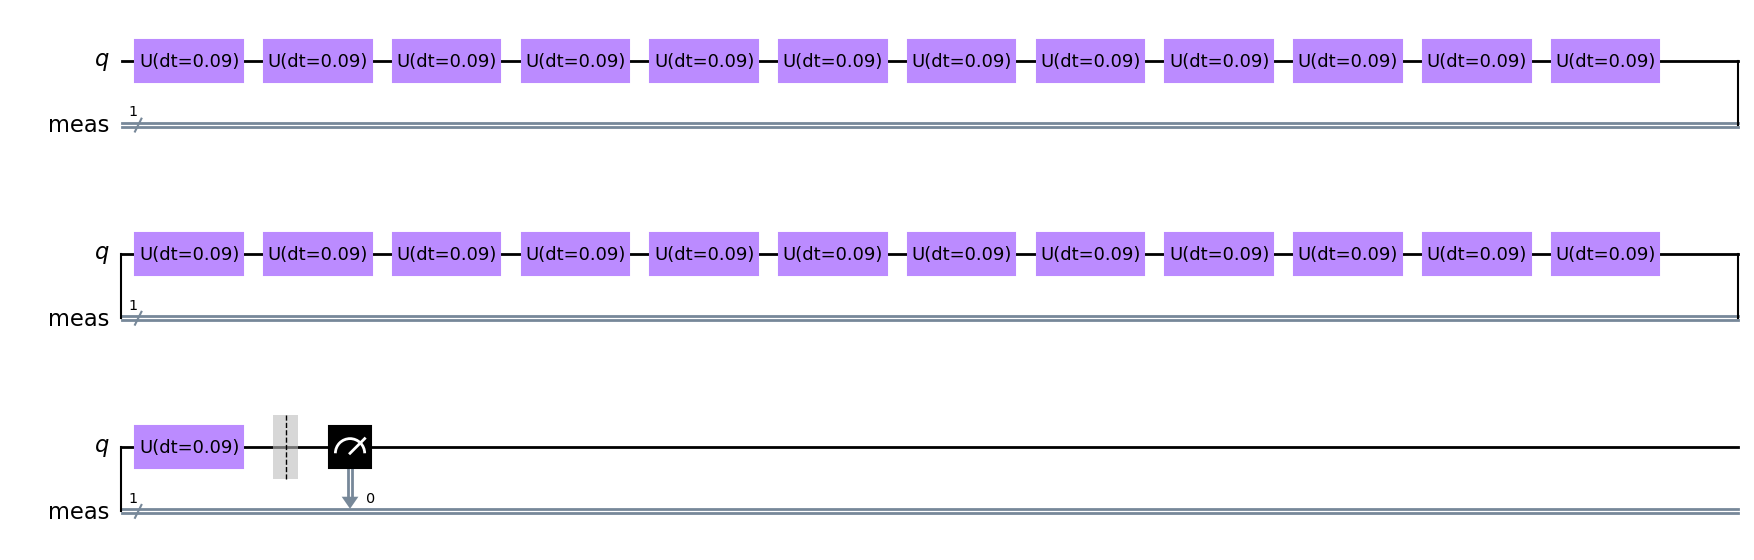

In [4]:
qc = QuantumCircuit(1)

for i in range(r):
    qc.append(U_t, [0])

qc.measure_all()
qc.draw(output='mpl')

Here's the resulting state vector

In [5]:
sim = Aer.get_backend('statevector_simulator')
results = execute(qc, backend=sim, shots=2000).result()
state_vec = results.get_statevector()
array_to_latex(state_vec)

<IPython.core.display.Latex object>

And here's the measured results

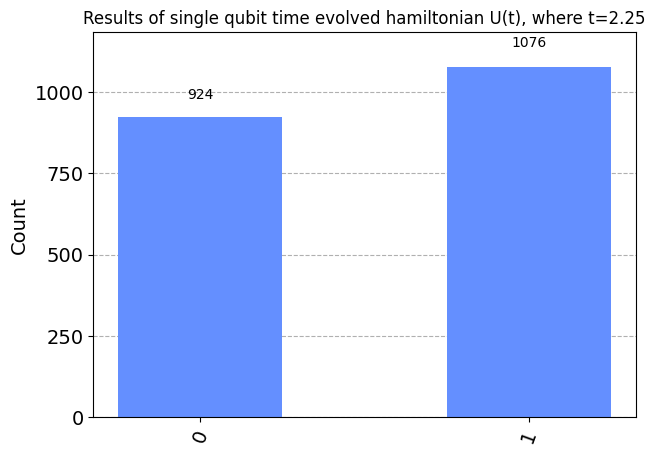

In [6]:
sim = Aer.get_backend('aer_simulator')
results = execute(qc, backend=sim, shots=2000).result()
counts = results.get_counts()
plot_histogram(counts, title="Results of single qubit time evolved hamiltonian U(t), where t={}".format(t))

## Part 2) Two Qubit Simulation

### A) Simulated Result

Let's now use a more complicated hamiltonian and compare its simulated results in qiskit with the actual results of a quantum solver. 

I've decided to choose to simulate the effective term of the Jaynes-Cummings Hamiltonian. This hamiltonian is an important one for quantum computing. It represents the energy transitions between a single qubit and a quantum harmonic oscillator its coupled to. Here it is below:

$$ H_{Eff} = \frac{-g^2}{4\delta} (\sigma_{+} \mathop{\otimes} \sigma_{-} + \sigma_{-} \mathop{\otimes} \sigma_{+}) $$

The time evolved unitary is therefore:

$$ U_{Eff}(t) = cos(\frac{g^2}{4\delta}t) \mathbb{I} + \mathbb{i}sin(\frac{g^2}{4\delta}t)(\sigma_{+}\mathop{\otimes}\sigma_{-} + \sigma_{-}\mathop{\otimes}\sigma_{+})  $$

Let's take this Hamiltonian and see what it would be for $g^2=\pi$, $\delta=0.25$, and $t=2.25$.

In [12]:
# Define all our hamiltonina params
g_sq = np.pi
delta = 0.25
t = 2.25

# Define our trotterization terms for simulation
r = 50
dt = t / r

eff_term = (g_sq / (4 * delta)) * dt

# The time evolved unitrary
I_comp = np.cos(eff_term) * tensor(qeye(2),qeye(2))
sig_comp = 1.j * np.sin(eff_term) * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))
U_eff = I_comp + sig_comp

array_to_latex(U_eff)

<IPython.core.display.Latex object>

However, this hamiltonian doesn't exactly look unitary. Let's prove that by multiplying it by its complex conjegate and see what we get:

In [13]:
U_eff_dag = U_eff.dag()
unitary_val = U_eff * U_eff_dag
array_to_latex(unitary_val)

<IPython.core.display.Latex object>

As we can see, this Hamiltonian is not quite unitary. Therefore we can use trotterization to estimate our non-unitary Hamiltonian as best as possible.

A good approximation of this Hamiltonian in a unitary form comes from the two qubit Rxy gate, which I've constructed below with the same 'eff_term' paramater 

In [41]:
qc = QuantumCircuit(2, name="U_eff(dt={})".format(dt))

phi = -2*eff_term
Rxy_op = Operator( [
    [1, 0, 0, 0],
    [0, np.cos(phi/2), -1.j * np.sin(phi/2), 0],
    [0, -1.j * np.sin(phi/2), np.cos(phi/2), 0],
    [0, 0, 0, 1] ])
array_to_latex(Rxy_op)

<IPython.core.display.Latex object>

In [54]:
class Rxy(Gate):
    def __init__(self, phi, label="Rxy"):
        super().__init__('U', 2, [phi], label=label)
    
    def _define(self):
        qc = QuantumCircuit(2)
        qc.unitary(self.to_matrix(), [0,1])
        self.definition = qc
    
    def to_matrix(self):
        phi = float(self.params[0])
        return np.array([[1, 0, 0, 0],
                         [0, np.cos(phi/2), -1.j * np.sin(phi/2), 0],
                         [0, -1.j * np.sin(phi/2), np.cos(phi/2), 0],
                         [0, 0, 0, 1] ])

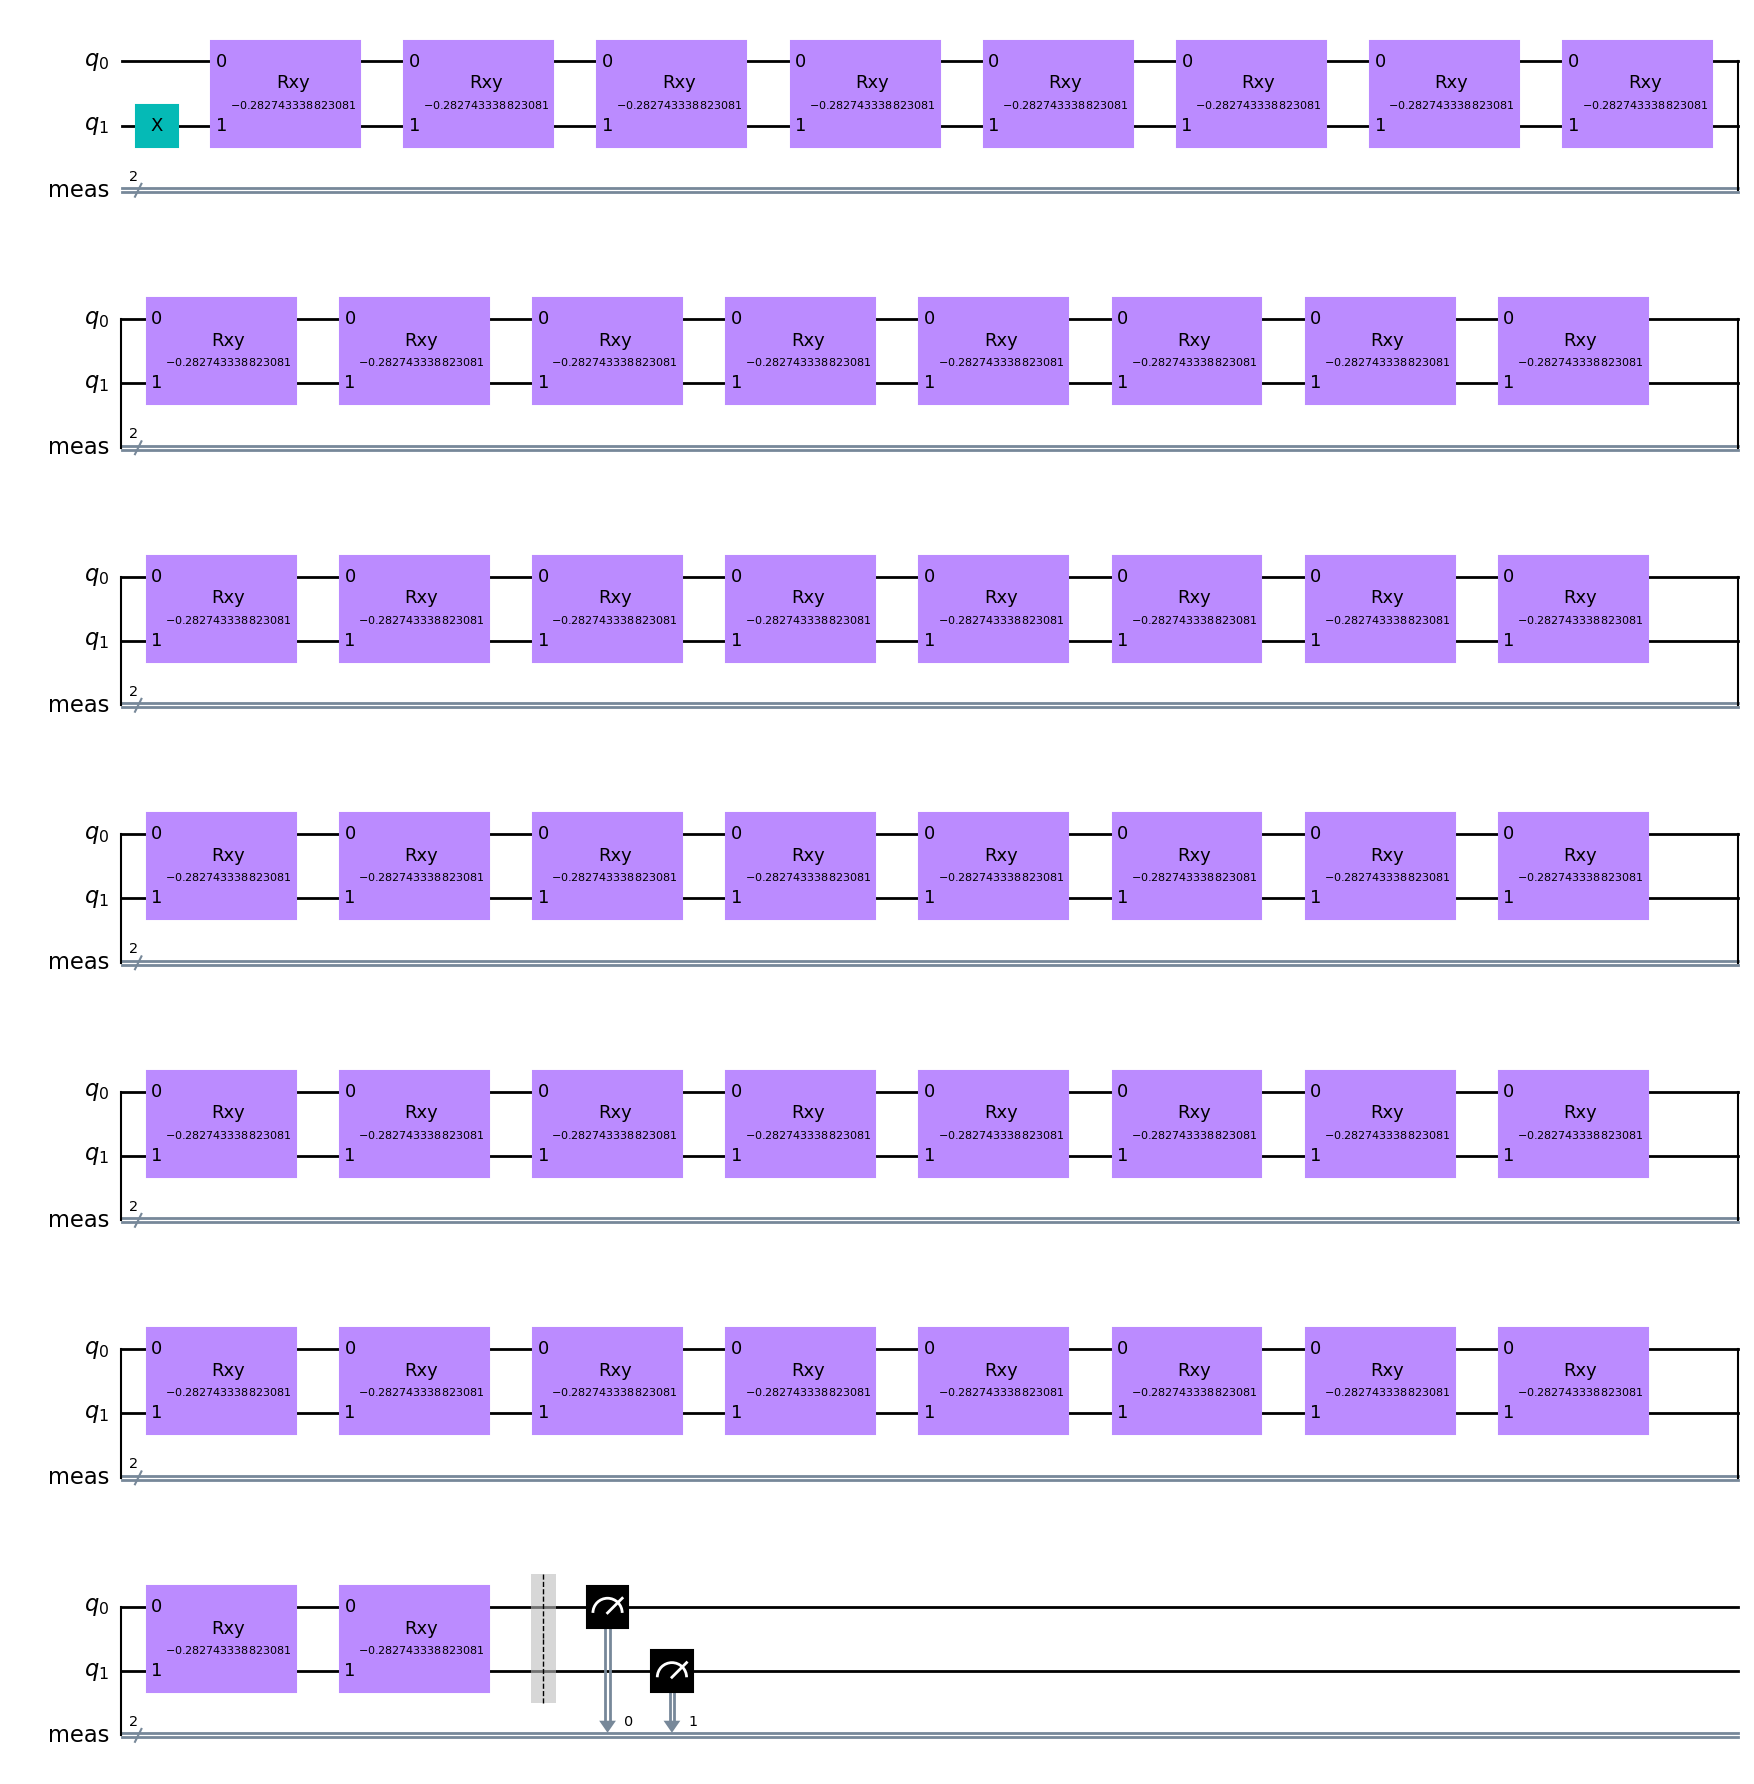

In [55]:
phi = Parameter("phi")
qc = QuantumCircuit(2)

qc.x(1)
for i in range(r):
    qc.append(Rxy(phi), [0,1])
qc.reverse_bits()
qc.measure_all()

bound_qc = qc.assign_parameters({ phi: -2*eff_term})
bound_qc.draw(output='mpl')

Now, lets take a look at our measured results:

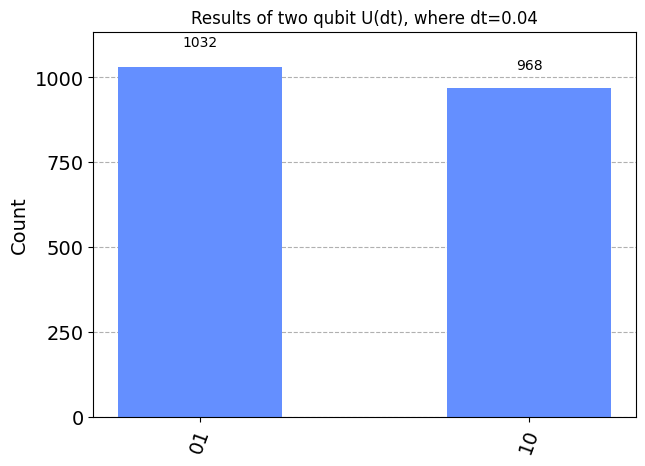

In [56]:
sim = Aer.get_backend('aer_simulator')
shots = 2000
results = execute(bound_qc, backend=sim, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts, title="Results of two qubit U(dt), where dt={:.2f}".format(dt))

### B) Actual Result

In [57]:
# The hamiltonian
eff_term_t = (g_sq / (4 * delta)) * t
H_eff = -eff_term_t * (tensor(sigmap(), sigmam()) + tensor(sigmam(), sigmap()))

{'00': 0.0, '01': 0.9619462435207664, '10': 0.03805375647923339, '11': 0.0}


<BarContainer object of 4 artists>

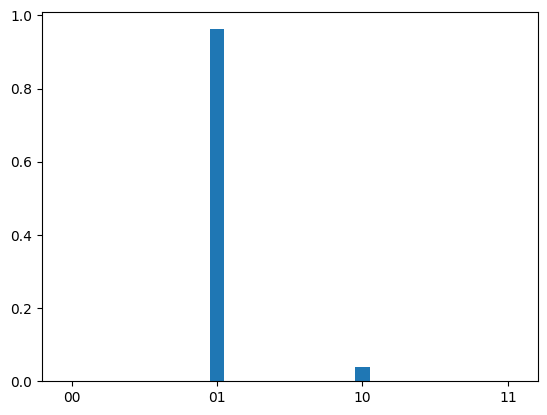

In [58]:
t_list = np.linspace(0, t, 100)
psi = tensor(fock(2,0), fock(2,1))

# Lets build our expectation values
eops = []
for i in range(0, 2):
    for j in range(0, 2):
        state = tensor(fock(2,i), fock(2,j))
        eops.append(state * state.dag())

# Compute solved result:
result = mesolve(H_eff, psi, t_list, e_ops=eops)
state00_res = result.expect[0]
state01_res = result.expect[1]
state10_res = result.expect[2]
state11_res = result.expect[3]
states = {
    '00': state00_res[-1], 
    '01': state01_res[-1], 
    '10': state10_res[-1], 
    '11': state11_res[-1]
}
print(states)
plt.bar(list(states.keys()), list(states.values()), width=0.1)